In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit,cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  accuracy_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
    

In [2]:
Og_df=pd.read_csv(r'C:\Users\mhuza\Desktop\MINI-Projects-ML\Driectory\loan_data_set.csv')
Og_df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
Og_df.isnull().sum()
# data is small and dropping NaN values would mean not enogh data to train our model effectively for unseen datasets
# so using modes for datasets seems like a viable option

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [4]:
# we will use simple mode_imputer in one for categorial features or features that have a low variance like dependents
#we will use mean for those features that have a large difference like the loan amount
mode_imputer=SimpleImputer(strategy='most_frequent')
mean_imputer=SimpleImputer(strategy="mean")
Og_df[['Gender','Married','Dependents','Self_Employed','Credit_History','Loan_Amount_Term']]=mode_imputer.fit_transform(Og_df[['Gender','Married','Dependents','Self_Employed','Credit_History','Loan_Amount_Term']])
Og_df['LoanAmount']=mean_imputer.fit_transform(Og_df[['LoanAmount']])
Og_df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

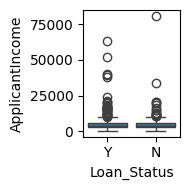

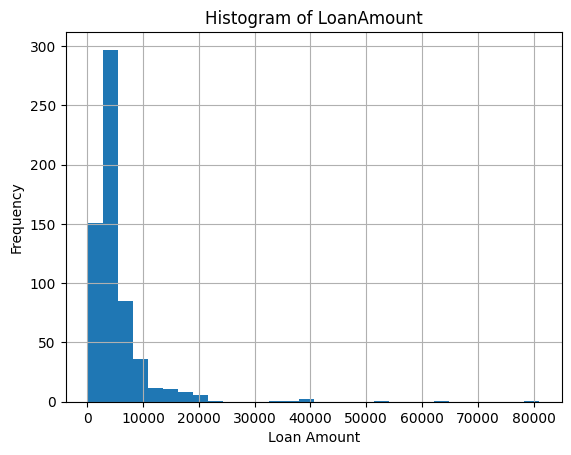

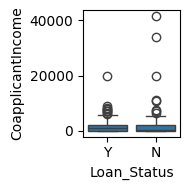

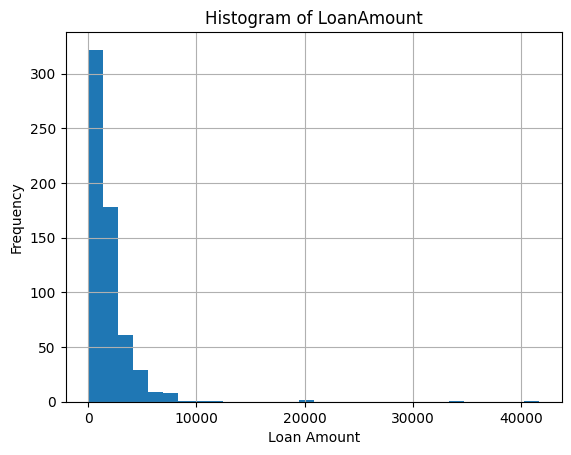

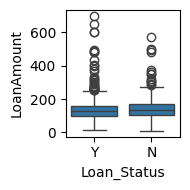

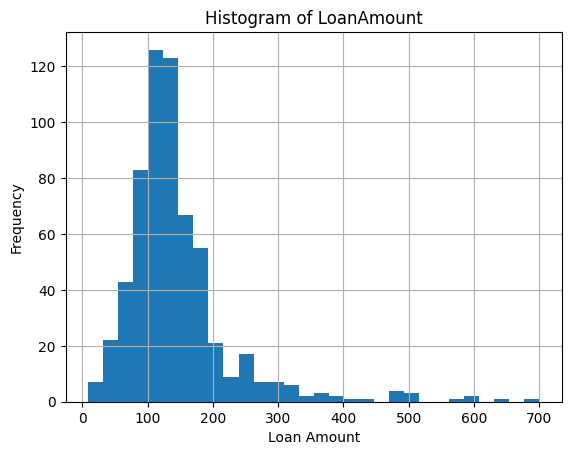

In [5]:

numerical_cols=Og_df.select_dtypes(include="number")
for cols in numerical_cols:
    plt.figure(figsize=(2,2))
    sns.boxplot(x='Loan_Status',y=cols,data=Og_df)
    plt.tight_layout()
    plt.show()
    Og_df[cols].hist(bins=30)
    plt.title("Histogram of LoanAmount")
    plt.xlabel("Loan Amount")
    plt.ylabel("Frequency")
    plt.show()
#the purpose for visualizing using boxplot was to actually see potential outliers
#now its absolutlety normal if there is a huge difference in the income levels or other features of loan seekers]
#but my main concern was to look for anomolies that could ruin my model prediction
#for that i used histograms

<Axes: xlabel='Loan_Status', ylabel='count'>

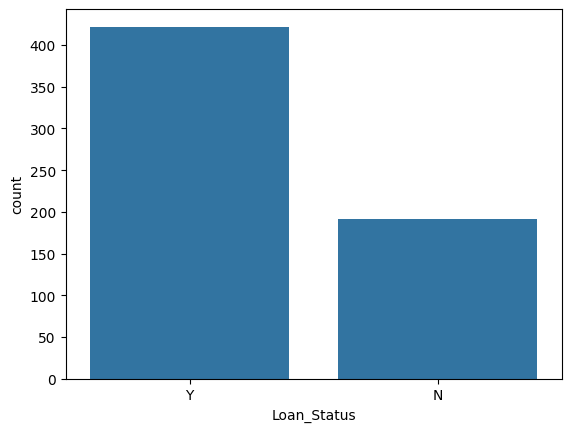

In [6]:
sns.countplot(x='Loan_Status',data=Og_df)

In [7]:
Og_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


In [8]:
# lets encode the categorial features using Label encoder-Label encoder assigns integers values to categorial columns
#Considering that we hacve dependents in our case we will use Label encoder
le=LabelEncoder()
Og_df['Dependents']=le.fit_transform(Og_df['Dependents'])
Og_df['Self_Employed']=le.fit_transform(Og_df['Self_Employed'])
Og_df['Education']=le.fit_transform(Og_df['Education'])
Og_df['Gender']=le.fit_transform(Og_df['Gender'])
Og_df['Married']=le.fit_transform(Og_df['Married'])
Og_df['Loan_Status']=le.fit_transform(Og_df['Loan_Status'])
Og_df['Property_Area']=le.fit_transform(Og_df['Property_Area'])

In [9]:
Og_df=Og_df.drop('Loan_ID',axis=1)
X=Og_df.drop('Loan_Status',axis=1).copy()
y=Og_df['Loan_Status']
X.head()
y.head()

0    1
1    0
2    1
3    1
4    1
Name: Loan_Status, dtype: int64

In [10]:
#The classes have almost a 2:1 Ratio, so they are moderately imbalanced
#lets create models with and without modifying data to see which performs the best on unseen data and real world
#since data is very less, to see which model performs best we would have to create folds and check the accuracy of our model on the unseed data


from sklearn.model_selection import StratifiedShuffleSplit
sss_for_folds=StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=40)
# I will be using smote to oversample the data because undersampling will cause data to be lost and since we already have less data to train our model, its not the best option to go by
# I will be using pipelines to reduce the amount of code and make it easier to train various models along with using smote 
#i will be scaling only the training data inside the loop to see how well each model performs
#scaling outside the loop can cause data leakages
#will be using pipelines in my case 


xgb_cv_score=[]
lr_cv_score=[]
dt_cv_score=[]
rf_cv_score=[]
for train_index, test_index in sss_for_folds.split(X,y):
    X_fold_train,x_fold_test=X.iloc[train_index],X.iloc[test_index]
    Y_fold_train,y_fold_test=y.iloc[train_index],y.iloc[test_index]

    # Logistic regression model
    lr_pipeline=Pipeline([
        ('scale',RobustScaler()),
        ('SMOTE',SMOTE(random_state=40)),
        ('lr', LogisticRegression(max_iter=1000))
    ])
    
    lrscore=cross_val_score(lr_pipeline,X_fold_train,Y_fold_train,cv=5,scoring='accuracy')
    lr_cv_score.append(lrscore.mean())

    # Xgboost model
    xgb_pipeline=Pipeline([
        ('scale',RobustScaler()),
        ('SMOTE',SMOTE(random_state=40)),
        ("xgb",XGBClassifier(random_state=40))
    ])

    xgb_score=cross_val_score(xgb_pipeline,X_fold_train,Y_fold_train,cv=5,scoring='accuracy')
    xgb_cv_score.append(xgb_score.mean())

    dt_pipeline=Pipeline([
        ('scale',RobustScaler()),
        ('SMOTE',SMOTE(random_state=40)),
        ('dt', DecisionTreeClassifier(random_state=40))
    ])
    dt_score=cross_val_score(dt_pipeline,X_fold_train,Y_fold_train,cv=5,scoring='accuracy')
    dt_cv_score.append(dt_score.mean())
    
    rf_pipeline=Pipeline([
        ('scale',RobustScaler()),
        ('SMOTE',SMOTE(random_state=40)),
        ('rf', RandomForestClassifier(random_state=40))
    ])
    rf_score=cross_val_score(rf_pipeline,X_fold_train,Y_fold_train,cv=5,scoring='accuracy')
    rf_cv_score.append(rf_score.mean())

    



print(f"Logistic Regression CV Accuracy: {np.mean(lr_cv_score)*100:.2f}% ± {np.std(lr_cv_score)*100:.2f}%")
print(f"XGBoost CV Accuracy: {np.mean(xgb_cv_score)*100:.2f}% ± {np.std(xgb_cv_score)*100:.2f}%")
print(f"Decision tree CV Accuracy: {np.mean(dt_cv_score)*100:.2f}% ± {np.std(dt_cv_score)*100:.2f}%")
print(f"Random CV Accuracy: {np.mean(rf_cv_score)*100:.2f}% ± {np.std(rf_cv_score)*100:.2f}%")

Logistic Regression CV Accuracy: 75.81% ± 1.21%
XGBoost CV Accuracy: 73.85% ± 1.79%
Decision tree CV Accuracy: 69.01% ± 1.12%
Random CV Accuracy: 76.01% ± 1.82%


In [11]:
sss_1_split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=40)
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')  # Converts object columns to float/int, sets bad values to NaN
for train_index_2, test_index_2 in sss_1_split.split(X,y):

    x_train,x_test=X.iloc[train_index_2],X.iloc[test_index_2]
    y_train,y_test=y.iloc[train_index_2],y.iloc[test_index_2]
    
xgb_model2=XGBClassifier(random_state=40)
xgb_model2.fit(x_train,y_train)
y_predict=xgb_model2.predict(x_test)
print(classification_report(y_test, y_predict))

lr_model2=LogisticRegression(random_state=40)
lr_model2.fit(x_train,y_train)
y_predict=lr_model2.predict(x_test)
print(classification_report(y_test, y_predict))

dt_model2=DecisionTreeClassifier()
dt_model2.fit(x_train,y_train)
y_predict=dt_model2.predict(x_test)
print(classification_report(y_test, y_predict))

rf_model2=RandomForestClassifier()
rf_model2.fit(x_train,y_train)
y_predict=rf_model2.predict(x_test)
print(classification_report(y_test, y_predict))


              precision    recall  f1-score   support

           0       0.57      0.42      0.48        38
           1       0.77      0.86      0.81        85

    accuracy                           0.72       123
   macro avg       0.67      0.64      0.65       123
weighted avg       0.71      0.72      0.71       123

              precision    recall  f1-score   support

           0       0.93      0.37      0.53        38
           1       0.78      0.99      0.87        85

    accuracy                           0.80       123
   macro avg       0.86      0.68      0.70       123
weighted avg       0.83      0.80      0.76       123

              precision    recall  f1-score   support

           0       0.56      0.61      0.58        38
           1       0.82      0.79      0.80        85

    accuracy                           0.73       123
   macro avg       0.69      0.70      0.69       123
weighted avg       0.74      0.73      0.73       123

              preci

c:\Users\mhuza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
